### Sensitivity of hydraulic head at a point to Robin boundary head value under steady state flow conditions

The sensitivity of hydraulic head ($h$) at a given point ($x'$) to the hydraulic head value specified on a Robin boundary (i.e. on $\Gamma_3$) under steady state flow conditions in a one-dimensional plane can be calculated using an adjoint state-based approach as:
$$\begin{align}\cr
\frac{\partial h(x')}{\partial h_{\Gamma_3}}=\oint\limits_{\Gamma_3} \psi^*(x)\;c_{\Gamma_3}\;dx
\cr\cr\end{align}$$
This expression states that this sensitivity is equal to the integral of the product of the Robin boundary conductance term with the adjoint state variable along the Robin boundary, as calculated by the adjoint state model.

### 1. Model setup

The forward model is defined using the following six parameters:
1. Location of Dirichlet boundary ($x_{\Gamma_1}$)
2. Hydraulic head specified on Dirichlet boundary ($h_{\Gamma_1}$) 
3. Location of Robin boundary ($x_{\Gamma_3}$)
4. Hydraulic head value specified on Robin boundary ($h_{\Gamma_3}$) 
5. Conductance value specified on Robin boundary ($c_{\Gamma_1}$) 
6. Hydraulic conductivity ($K$)

Top and bottom of aquifer elevations are set to -100.0 and -101.0 metres respectively (resulting in an aquifer that is one metre thick) to ensure confined conditions.

Robin boundary conditions are specified on the left-hand side of the model to represent inflows.

Dirichlet boundary conditions are specified on the right-hand side of the model to represent outflows.

The hydraulic head observation of interest is located at the midpoint of the model domain (i.e. at $x_{obs}$).

Values for the 'base' parameter set are defined as follows. These can be modified to demonstrate the method for other model configurations.

In [1]:
import numpy as np

BC1x  = 7.0
BC1h  = 1.0
BC3x  = 0.0
BC3h  = 40.0
BC3c  = 1.0
obsx  = (BC1x-BC3x)/2.
K     = 0.2
dpar  = 1e-4
dx    = 1.0
X     = np.arange(BC3x+0.5, BC1x-0.5+dx, dx)

The forward model and boundary conditions can be presented visually as follows.

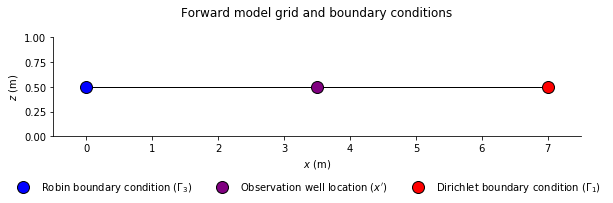

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_aspect(1.5)
s.set_title('Forward model grid and boundary conditions\n')
s.set_xlim(BC3x-0.5, BC1x+0.5)
s.set_ylim(0., 1.)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.plot([BC3x, BC1x], [0.5, 0.5], 'k-', lw=1.)
s.plot(BC3x, 0.5, 'o', ms=12, mfc='b', mec='k', label='Robin boundary condition ($\Gamma_3$)') 
s.plot(obsx, 0.5, 'o', ms=12, mfc='purple', mec='k', label="Observation well location ($x'$)") 
s.plot(BC1x, 0.5, 'o', ms=12, mfc='r', mec='k', label='Dirichlet boundary condition ($\Gamma_1$)') 
s.spines['right'].set_visible(False)
s.spines['top'].set_visible(False)
l = f.legend(fancybox=False, frameon=False, loc=8, ncol=3)

### 2. Sensitivity calculation using perturbation-based approach

First, the forward model featuring the 'base' parameter set is run.

In [3]:
import timml

ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head=BC1h)
BC3 = timml.ResLineSink( ml, x1=BC3x, y1=-100., x2=BC3x, y2=100., head=BC3h, res=BC3c, width=1.)
ml.solve()

hds_base = np.array([ml.head(0, x, 0.) for x in X])
hob_base = ml.head(0, obsx, 0.)

Starting solve
Number of elements:  2
Percent progress:  0  
size of matrix (2L, 2L)
Solution complete


The spatial distribution of hydraulic head calculated by the 'base' forward model can be presented visually as follows.

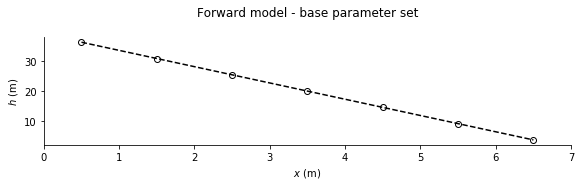

In [4]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Forward model - base parameter set\n')
s.set_aspect(0.04)
s.plot(X, hds_base, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$h$ (m)')
s.set_xlim(BC3x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False) 

Second, a perturbed forward model featuring an infinitesimal increase in $BC3\_h$ is run. 

In [5]:
ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head=BC1h)
BC3 = timml.ResLineSink( ml, x1=BC3x, y1=-100., x2=BC3x, y2=100., head=BC3h*(1.+dpar), res=BC3c, width=1.)
ml.solve()

hds_pert = np.array([ml.head(0, x, 0.) for x in X])
hob_pert = ml.head(0, obsx, 0.)

Starting solve
Number of elements:  2
Percent progress:  0  
size of matrix (2L, 2L)
Solution complete


The spatial distribution of hydraulic head calculated by the perturbed forward model can be presented visually as follows.

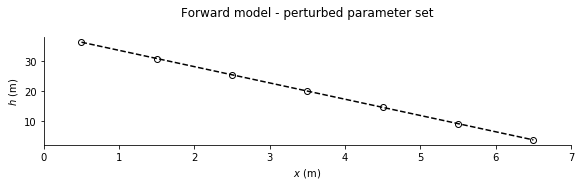

In [6]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Forward model - perturbed parameter set\n')
s.set_aspect(0.04)
s.plot(X, hds_pert, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$h$ (m)')
s.set_xlim(BC3x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False)            

Third, the perturbation-based sensitivity is calculated.

In [7]:
dh_dBC3h_pert = (hob_pert-hob_base)/(BC3h*dpar)

### 3. Sensitivity calculation using adjoint state-based approach

First, the adjoint state model is defined. This is mostly identical to the forward model, except for three conditions: 
1. The value specified on the Dirichlet boundary is set to zero.
2. The flux specified on the Neumann boundary is set to zero; for this reason, a no-flow boundary condition is applied instead.
3. A constant source of adjoint state is specified at the location of the hydraulic head observation of interest using a  source term with flux magnitude equal to unity.

In [8]:
ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head = 0.0)
BC3 = timml.ResLineSink( ml, x1=BC3x, y1=-100., x2=BC3x, y2=100., head = 0.0, res=BC3c, width=1.)
lt  = timml.LineSink(    ml, x1=obsx, y1=-100., x2=obsx, y2=100., sigma=-1.0)
ml.solve()

adj = np.array([ml.head(0, x, 0.) for x in X])

Starting solve
Number of elements:  3
Percent progress:  0  
size of matrix (2L, 2L)
Solution complete


The adjoint state model grid and boundary conditions can be presented visually as follows.

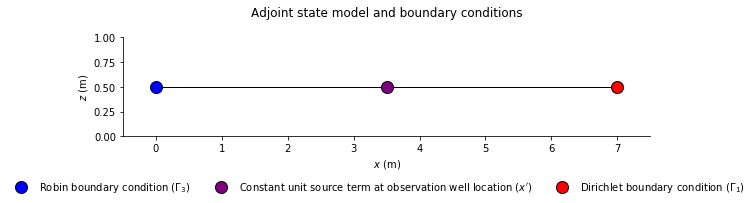

In [9]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_aspect(1.5)
s.set_title('Adjoint state model and boundary conditions\n')
s.set_xlim(BC3x-0.5, BC1x+0.5)
s.set_ylim(0., 1.)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.plot([BC3x, BC1x], [0.5, 0.5], 'k-', lw=1.)
s.plot(BC3x, 0.5, 'o', ms=12, mfc='b', mec='k', label='Robin boundary condition ($\Gamma_3$)') 
s.plot(obsx, 0.5, 'o', ms=12, mfc='purple', mec='k', 
       label="Constant unit source term at observation well location ($x'$)") 
s.plot(BC1x, 0.5, 'o', ms=12, mfc='r', mec='k', 
       label='Dirichlet boundary condition ($\Gamma_1$)') 
s.spines['right'].set_visible(False)
s.spines['top'].set_visible(False)
l = f.legend(fancybox=False, frameon=False, loc=8, ncol=3)

The spatial distribution of the adjoint state variable calculated by the adjoint model can be presented visually as follows. Note that the value of the adjoint state variable is zero at the right-most cell; this is because the Dirichlet boundary condition is zero-valued in the adjoint state model.

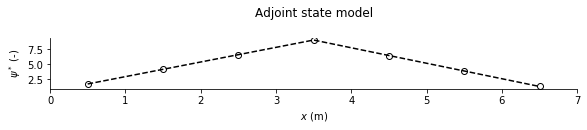

In [10]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Adjoint state model\n')
s.set_aspect(0.08)
s.plot(X, adj, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$\psi^*$ (-)')
s.set_xlim(BC3x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False)            

Second, the adjoint state sensitivity is calculated. For this example [i.e. for the sensitivity $\partial h(x')/\partial K$], this is calculated using a combination of forward and adjoint model outputs, as described by the equation presented above.

In [13]:
dh_dBC3h_adj  = ml.head(0, BC3x, 0.)*BC3c

This comparison of divergence term values shows that the contribution of cells located upgradient of the observation location to the adjoint sensitivity will be zero.

### 4. Comparison of calculated sensitivities

In [14]:
print 'Perturbation-based sensitivity  = '+str('%14.6f'%  dh_dBC3h_pert)
print 'Adjoint state-based sensitivity = '+str('%14.6f'%  dh_dBC3h_adj)
print
print 'Ratio                           = '+str('%14.6e'% (dh_dBC3h_pert/dh_dBC3h_adj))
print 'Difference (absolute)           = '+str('%14.6e'% (dh_dBC3h_adj-dh_dBC3h_pert))
print 'Difference (percent)            = '+str('%14.6e'%  abs((dh_dBC3h_adj-dh_dBC3h_pert)/dh_dBC3h_pert))

Perturbation-based sensitivity  =       0.484708
Adjoint state-based sensitivity =       0.484708

Ratio                           =   1.000000e+00
Difference (absolute)           =  -7.389644e-12
Difference (percent)            =   1.524556e-11
